In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import tensorflow.contrib.slim as slim  
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from gumbel import *
from ops import *
Bernoulli = tf.contrib.distributions.Bernoulli

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Config(object):
    init_scale = 0.1
    training_epochs = 25
    batch_size = 128
    display_step = 100
    lr = 0.001
    max_grad_norm = 0.25
    vocab_size = 10000
    tau0=5.0 # initial temperature
    ANNEAL_RATE=0.1
    MIN_TEMP=0.1
    beta = 0.001
    display_step =100
    obj = 'ER' # 'MLE','VB','ER'
    
    # Network Parameters
    input_size = 28
    hidden_size = 128
    output_size = 10
    num_steps = 28 # timesteps
    num_layers = 1
    output_size = 10
    K= 8

def Dropoutcell(config, is_training):
    cell = tf.contrib.rnn.BasicLSTMCell(config.hidden_size, forget_bias=0.0,state_is_tuple=True)
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(cell,
                                             output_keep_prob=config.keep_prob,
                                             variational_recurrent=False,
                                             dtype=tf.float32)
    return cell

In [4]:
class Model(object):
    def __init__(self, is_training, config):
        training = tf.placeholder(tf.bool)
        self.batch_size = config.batch_size
        self.num_steps = config.num_steps
        self.tau = tf.Variable(0.0, trainable=False)
        self.lr  = tf.Variable(0.0, trainable=False)
        self.input = tf.placeholder("float", [None, self.num_steps, config.input_size])
        self.targets = tf.placeholder("float", [None, config.output_size])
        
        with tf.variable_scope("model", reuse=tf.AUTO_REUSE ):
            self.initial_state = tf.zeros([self.batch_size,config.hidden_size*2])
            
            self.state = self.initial_state
            self.outputs = []
            self.ALL_z = []
            self.ALL_qz = []
            self.ALL_h = []
            self.ALL_state = []
        with tf.variable_scope("MRNN", reuse=tf.AUTO_REUSE):
            for time_step in range(self.num_steps):
                old_h, old_c = tf.split(value=self.state, num_or_size_splits=2, axis=1)
                with tf.variable_scope('logit_enc'):
                    logit_z = linear(self.input[:,time_step,:], config.K, name='x_zin') + \
                                linear(old_h, config.K, name='h_zin')
                q_z = tf.nn.softmax(logit_z)
                if is_training is True:
                    z = gumbel_softmax(logit_z,self.tau,hard=False)
                else:
                    z = softmax_sample(logit_z)
                self.ALL_z.append(z)
                self.ALL_qz.append(q_z)

                gates = linear(tf.concat([self.input[:,time_step,:], old_h], 1),\
                               config.hidden_size*config.K*4, name='gate')
                i, g, f, o = tf.split(value=gates, num_or_size_splits=4, axis=1)
                old_c_K = tf.tile(old_c,[1,config.K])
                new_c_K = tf.multiply(tf.sigmoid(f), old_c_K) + tf.multiply(tf.sigmoid(i), tf.tanh(g))
                new_h_K = tf.multiply(tf.sigmoid(o), tf.tanh(new_c_K))
                new_c_K = tf.reshape(new_c_K, [self.batch_size,config.K,config.hidden_size])
                new_h_K = tf.reshape(new_h_K, [self.batch_size,config.K,config.hidden_size])
                new_h = tf.einsum('nkd,nk->nd',new_h_K,z)
                new_c = tf.einsum('nkd,nk->nd',new_c_K,z)
                self.state = tf.concat([new_h, new_c], 1)
                self.ALL_h.append(new_h)
                self.ALL_state.append(self.state)
            self.logits = linear(new_h, config.output_size)
            
        self.NLL = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.targets)
        
        ALL_q_z_tmp = tf.transpose(self.ALL_qz,[1,0,2])
        entropy = -ALL_q_z_tmp*tf.log(ALL_q_z_tmp+1e-20)
        self.entropy = tf.reduce_mean(tf.reduce_sum(entropy,[1, 2]))
        
        if config.obj == 'ER':
            self.cost = tf.reduce_mean(self.NLL) - config.beta*self.entropy
        elif config.obj == 'VB':
            self.cost = tf.reduce_mean(self.NLL) - self.entropy
        elif config.obj == 'MLE':
            self.cost = tf.reduce_mean(self.NLL)
            
        self.correct_pred = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.targets,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        if not is_training:
            return
    
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.cost)
    
        self.new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self.lr_update = tf.assign(self.lr, self.new_lr)
        self.new_tau = tf.placeholder(tf.float32, shape=[], name="new_tau")
        self.tau_update = tf.assign(self.tau, self.new_tau)
        
    def assign_lr(self, session, lr_value):
        session.run(self.lr_update, feed_dict={self.new_lr: lr_value})
    def assign_tau(self, session, tau_value):
        session.run(self.tau_update, feed_dict={self.new_tau: tau_value})

In [5]:
config = Config()
eval_config = Config()
eval_config.batch_size = 1
eval_config.num_steps = 1

import os
if config.obj == 'ER':
    URL = './checkpoint/K='+str(config.K)+'_ER'+'_beta='+str(config.beta)
else:
    URL = './checkpoint/K='+str(config.K)+'_'+str(config.obj)
if not os.path.exists(URL):
    os.makedirs(URL)

initializer = tf.random_uniform_initializer(-config.init_scale,config.init_scale)

with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None, initializer=initializer):
        m = Model(is_training=True, config=config)

with tf.name_scope("Valid"):
    with tf.variable_scope("Model", reuse=True, initializer=initializer):
        mvalid = Model(is_training=False, config=config)

with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True, initializer=initializer):
        mtest = Model(is_training=False, config=config)

In [6]:
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Launch the graph
sess = tf.Session()
sess.run(init)
training_mis = []
training_loss = []
training_res = []
training_KL = []
valid_loss = [np.inf]
m.assign_lr(sess, config.lr)

# Training cycle
for epoch in range(config.training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/config.batch_size)
    
    # Loop over all batches
    for i in range(total_batch):
        start = time.time()
        batch_x, batch_y = mnist.train.next_batch(config.batch_size)
        
        # Run optimization op (backprop) and cost op (to get loss value)
        batch_x = batch_x.reshape((config.batch_size, config.num_steps, config.input_size))
        np_temp=np.maximum(config.tau0*np.exp(-config.ANNEAL_RATE*epoch),config.MIN_TEMP)
        m.assign_tau(sess, np_temp)
        temp_lr, temp_tau = sess.run([m.lr, m.tau])
        
        _, c, acc = sess.run([m.train_op, m.cost, m.accuracy], feed_dict={m.input: batch_x, \
                                                                            m.targets: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
        training_mis.append(1-acc)
        training_loss.append(c)
        end = time.time()
        train_time = (end-start) * config.display_step
        if (i+1) % config.display_step == 0:
            # Calculate batch loss and accuracy
            print ("Iter " + str((i+1)*config.batch_size) + \
                    ", Minibatch Loss= " + "{:.6f}".format(c) + \
                    ", Training Accuracy= " + "{:.5f}".format(acc) +\
                    ", Training Time= " + "{:.3f}".format(train_time))
            
    print("Learning rate: %f, Temperature: %f" % (temp_lr, temp_tau))
    print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(avg_cost))
    print('-'*50)
    avg_cost = 0.
    avg_acc = 0.
    total_batch = int(mnist.test.num_examples/config.batch_size)
    
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = mnist.test.next_batch(config.batch_size)
        
        # Run optimization op (backprop) and cost op (to get loss value)
        batch_x = batch_x.reshape((config.batch_size, config.num_steps, config.input_size))
        c, acc = sess.run([mvalid.cost, mvalid.accuracy], feed_dict={mvalid.input: batch_x, \
                                                                       mvalid.targets: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
        avg_acc += acc / total_batch
    valid_loss.append(avg_cost)
    print("Valid_cost=","{:.9f}".format(avg_cost))
#     if epoch > 10:
#         if valid_loss[-2] - valid_loss[-1] < 0:
#             break
    print('-'*50)
saver.save(sess, URL+"/model.ckpt")
print("Optimization Finished!")

Iter 12800, Minibatch Loss= 1.108565, Training Accuracy= 0.60938, Training Time= 3.596
Iter 25600, Minibatch Loss= 0.651674, Training Accuracy= 0.75781, Training Time= 3.904
Iter 38400, Minibatch Loss= 0.407165, Training Accuracy= 0.86719, Training Time= 3.622
Iter 51200, Minibatch Loss= 0.368835, Training Accuracy= 0.85156, Training Time= 3.633
Learning rate: 0.001000, Temperature: 5.000000
Epoch: 0001 cost= 0.863020069
--------------------------------------------------
Valid_cost= 0.667721297
--------------------------------------------------
Iter 12800, Minibatch Loss= 0.340252, Training Accuracy= 0.89062, Training Time= 3.576
Iter 25600, Minibatch Loss= 0.298100, Training Accuracy= 0.90625, Training Time= 3.657
Iter 38400, Minibatch Loss= 0.091619, Training Accuracy= 0.96094, Training Time= 3.591
Iter 51200, Minibatch Loss= 0.239189, Training Accuracy= 0.89844, Training Time= 3.629
Learning rate: 0.001000, Temperature: 4.524187
Epoch: 0002 cost= 0.274522667
------------------------

Valid_cost= 0.068785719
--------------------------------------------------
Iter 12800, Minibatch Loss= -0.028137, Training Accuracy= 0.98438, Training Time= 3.585
Iter 25600, Minibatch Loss= -0.021179, Training Accuracy= 0.98438, Training Time= 3.590
Iter 38400, Minibatch Loss= 0.011388, Training Accuracy= 0.97656, Training Time= 3.602
Iter 51200, Minibatch Loss= -0.025833, Training Accuracy= 0.99219, Training Time= 3.633
Learning rate: 0.001000, Temperature: 1.115651
Epoch: 0016 cost= -0.020070283
--------------------------------------------------
Valid_cost= 0.037405896
--------------------------------------------------
Iter 12800, Minibatch Loss= -0.048633, Training Accuracy= 1.00000, Training Time= 3.647
Iter 25600, Minibatch Loss= -0.028261, Training Accuracy= 0.99219, Training Time= 3.611
Iter 38400, Minibatch Loss= -0.051523, Training Accuracy= 1.00000, Training Time= 3.611
Iter 51200, Minibatch Loss= -0.004559, Training Accuracy= 0.97656, Training Time= 3.635
Learning rate: 0.0

In [7]:
# Testing cycle
for epoch in range(1):
    avg_cost = 0.
    avg_acc = 0.
    total_batch = int(mnist.test.num_examples/config.batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = mnist.test.next_batch(config.batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        batch_x = batch_x.reshape((config.batch_size, config.num_steps, config.input_size))
        c, acc = sess.run([mvalid.cost, mvalid.accuracy], feed_dict={mvalid.input: batch_x, \
                                                                       mvalid.targets: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
        avg_acc += acc / total_batch


print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(avg_cost), "acc=","{:.9f}".format(avg_acc))


Epoch: 0001 cost= 0.010595969 acc= 0.981270032


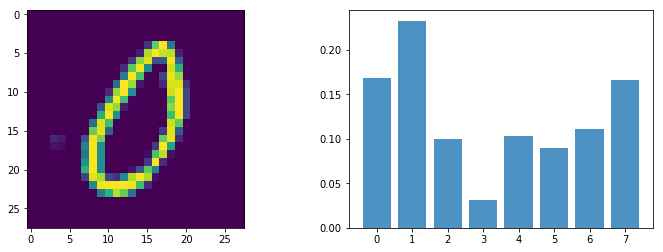

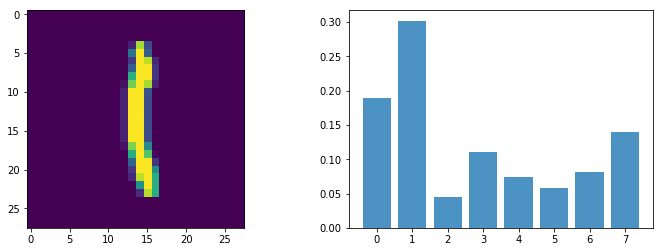

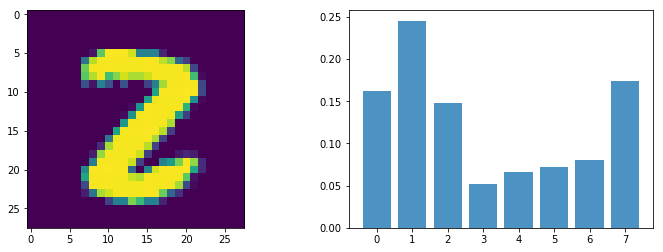

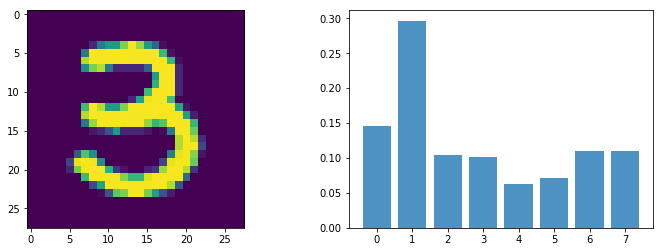

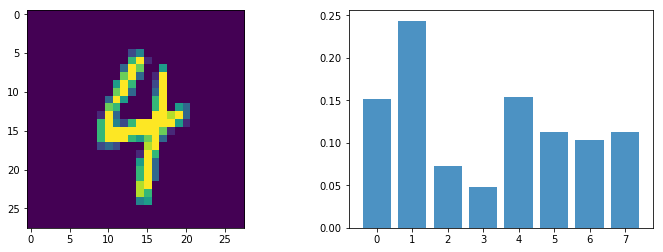

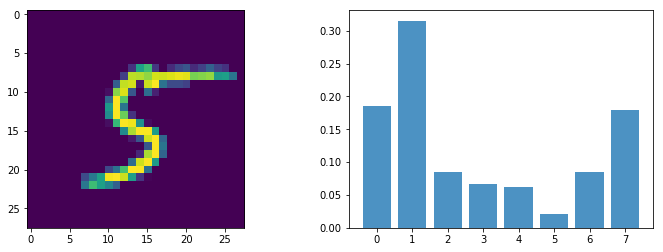

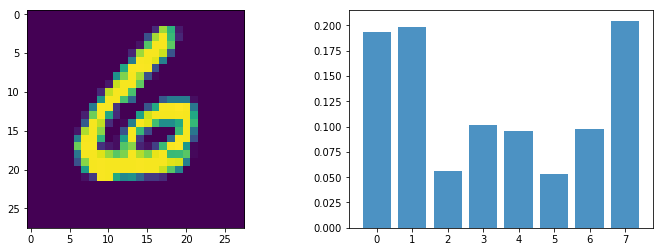

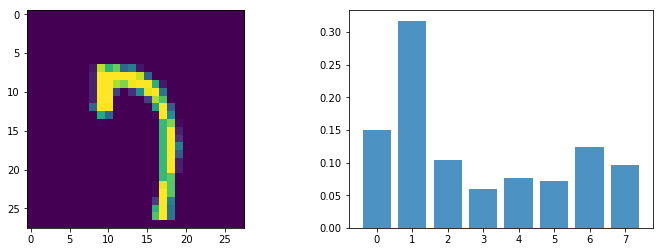

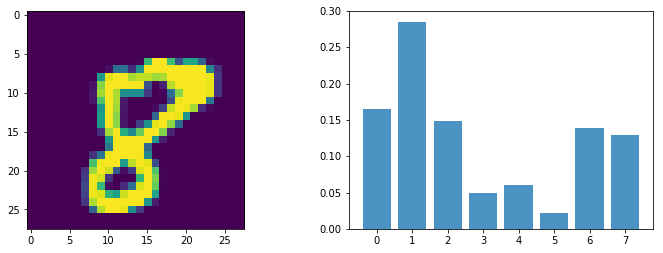

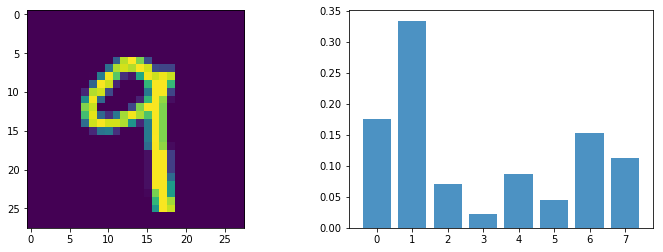

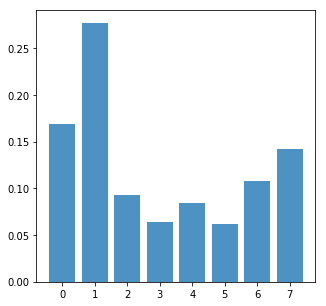

In [8]:
Total_prob = 0
eval_config = Config()
for i in range(10):
    temp_data = mnist.train.images[mnist.train.labels[:,i]==1,:]
    temp_label = mnist.train.labels[mnist.train.labels[:,i]==1,:]
    temp_im = np.reshape(temp_data,[-1,eval_config.num_steps,eval_config.input_size])
    batch_size = temp_im.shape[0]
    eval_config.batch_size = batch_size
    with tf.variable_scope("Model", reuse=True, initializer=initializer):
        temp_m = Model(is_training=False, config=eval_config)
    temp_z = sess.run(temp_m.ALL_z, feed_dict={temp_m.input: temp_im, temp_m.targets: temp_label})
    temp_z = np.transpose(temp_z, (1, 0, 2))
    prob = np.einsum('ijk->k',temp_z)/np.sum(temp_z)
    Total_prob += prob
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(temp_im[0])
    
    plt.subplot(1,2,2)
    xs = np.arange(eval_config.K)
    plt.bar(xs, prob, alpha=0.8)
    plt.savefig(URL+'/dist_'+str(i)+'.png')
    plt.show()
    
    
Total_prob = Total_prob/10
xs = np.arange(eval_config.K)
plt.figure(figsize=(5,5))
plt.bar(xs, Total_prob, alpha=0.8)
plt.savefig(URL+'/stat.png')
plt.show()

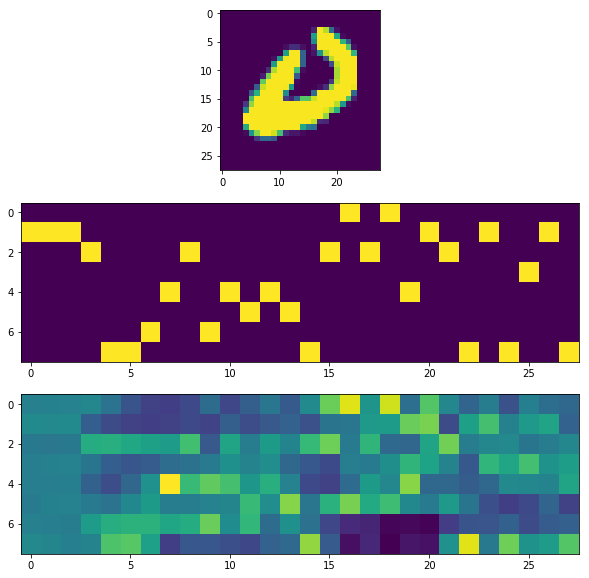

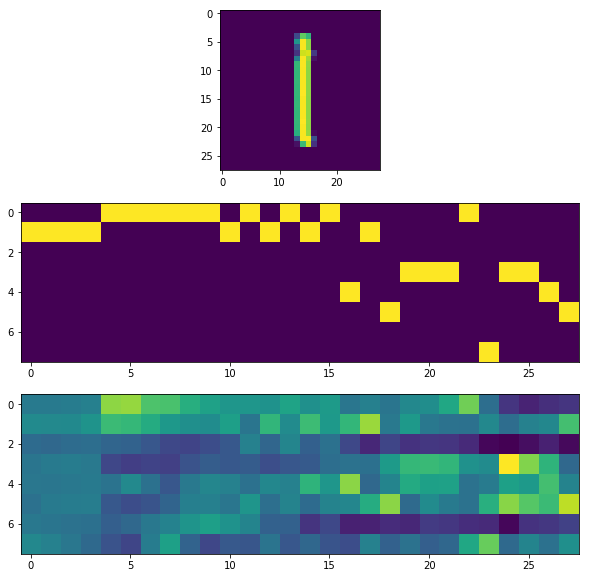

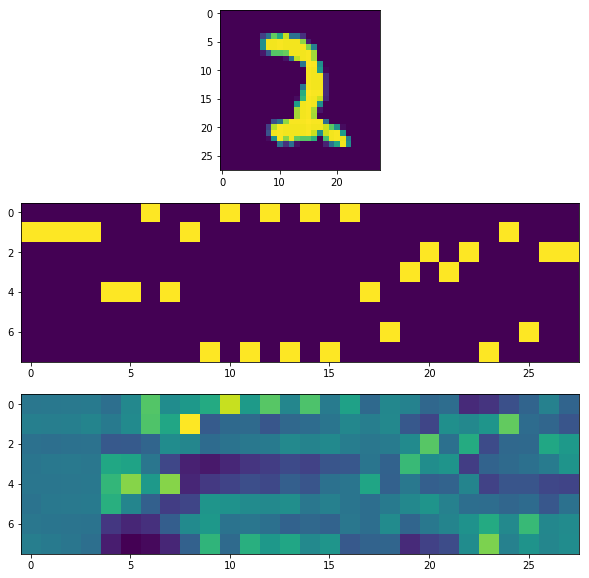

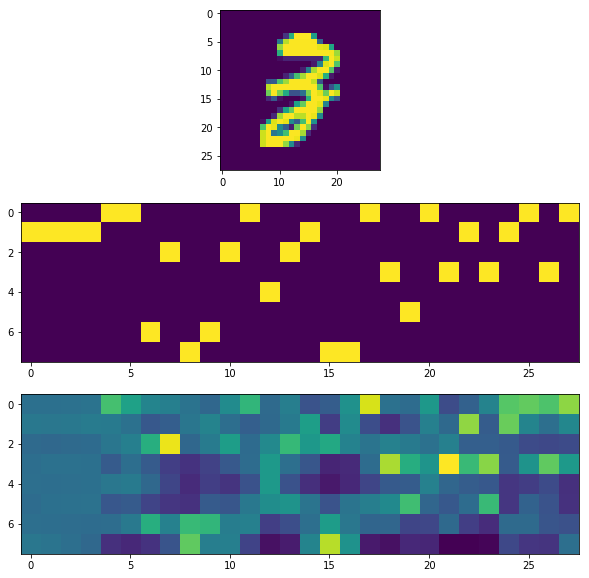

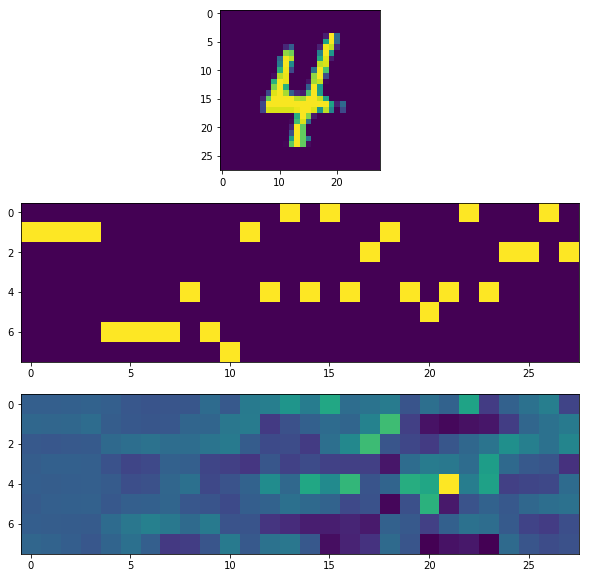

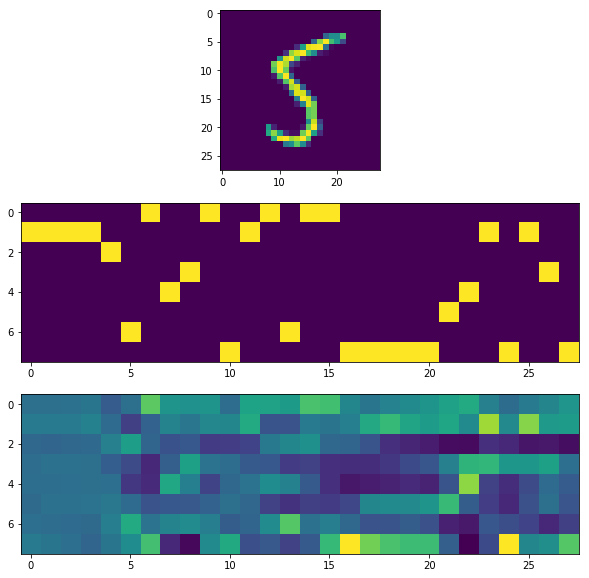

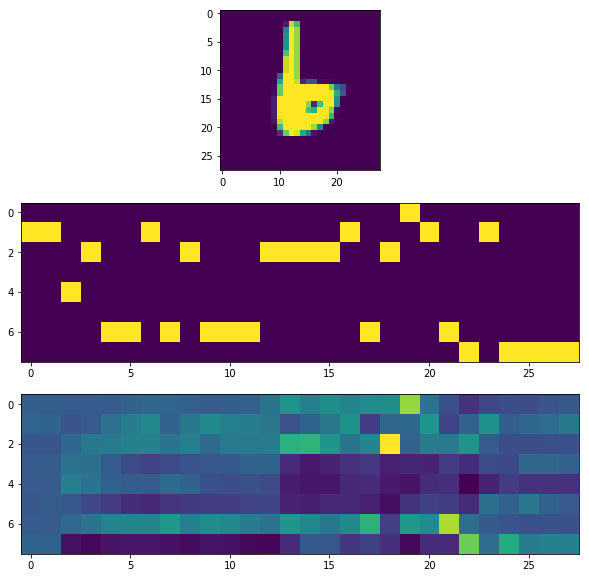

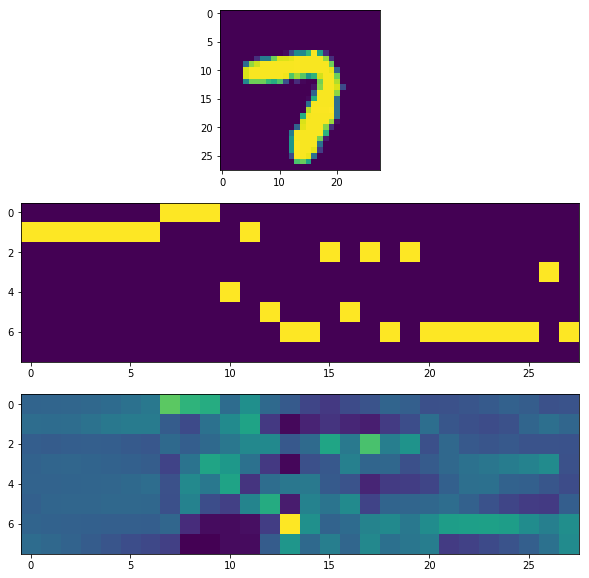

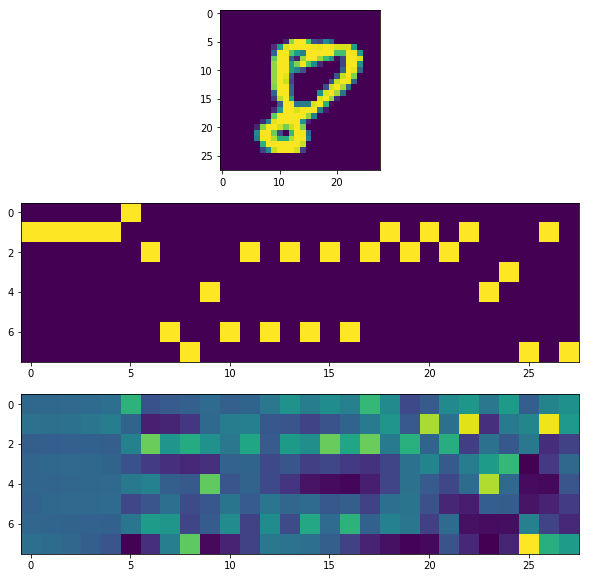

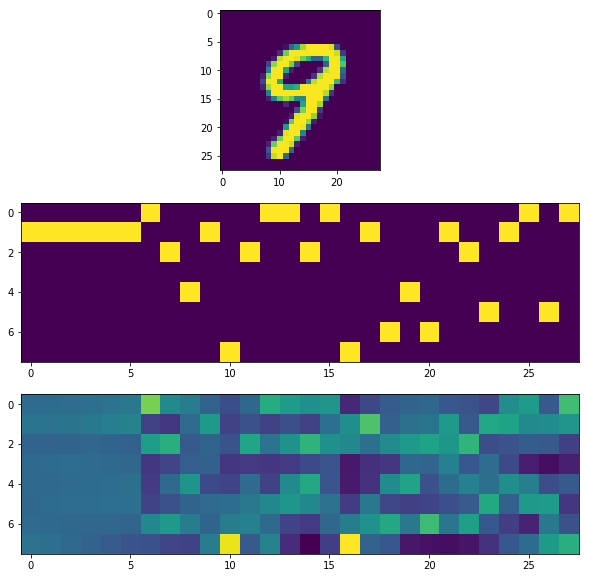

In [9]:
index = 2
for i in range(10):
    temp_data = mnist.train.images[mnist.train.labels[:,i]==1,:]
    temp_label = mnist.train.labels[mnist.train.labels[:,i]==1,:]
    temp_im = np.reshape(temp_data,[-1,config.num_steps,config.input_size])
    batch_x = temp_im[:config.batch_size,:]
    batch_y = temp_label[:config.batch_size,:]
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.imshow(batch_x[index])
    temp_z, temp_q_z = sess.run([mvalid.ALL_z, mvalid.ALL_qz], feed_dict={mvalid.input: batch_x, mvalid.targets: batch_y})
    temp_z = np.transpose(temp_z, (1, 0, 2))
    temp = temp_q_z
    temp_q_z = np.transpose(temp_q_z, (1, 0, 2))
    plt.subplot(3,1,2)
    plt.imshow(temp_z[index].T)
    plt.subplot(3,1,3)
    plt.imshow(temp_q_z[index].T)
    plt.savefig(URL+'/state_'+str(i)+'.png')
    plt.show()

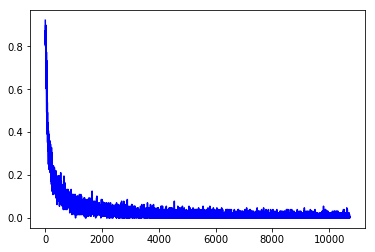

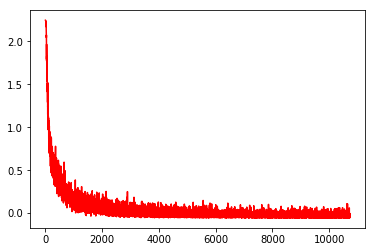

In [10]:
# Plot learning curve
plt.figure()
plt.plot(range(1,len(training_mis)+1),training_mis,'b')
plt.show()
plt.figure()
plt.plot(range(1,len(training_loss)+1),training_loss,'r')
plt.show()